### Honor Track: experience replay
_This notebook builds upon `qlearning.ipynb`, or to be exact, generating qlearning.py._

There's a powerful technique that you can use to improve sample efficiency for off-policy algorithms: [spoiler] Experience replay :)

The catch is that you can train Q-learning and EV-SARSA on `<s,a,r,s'>` tuples even if they aren't sampled under current agent's policy. So here's what we're gonna do:

<img src=https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/exp_replay.png width=480>

#### Training with experience replay
1. Play game, sample `<s,a,r,s'>`.
2. Update q-values based on `<s,a,r,s'>`.
3. Store `<s,a,r,s'>` transition in a buffer. 
 3. If buffer is full, delete earliest data.
4. Sample K such transitions from that buffer and update q-values based on them.


To enable such training, first we must implement a memory structure that would act like such a buffer.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

#XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

Starting virtual X frame buffer: Xvfb.
env: DISPLAY=:1


In [2]:
import random
class ReplayBuffer(object):
    def __init__(self, size):
        """
        Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
            
        Note: for this assignment you can pick any data structure you want.
              If you want to keep it simple, you can store a list of tuples of (s, a, r, s') in self._storage
              However you may find out there are faster and/or more memory-efficient ways to do so.
        """
        self._storage = []
        self._maxsize = size
        
        # OPTIONAL: YOUR CODE
        self._index = 0

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        '''
        Make sure, _storage will not exceed _maxsize. 
        Make sure, FIFO rule is being followed: the oldest examples has to be removed earlier
        '''
        data = (obs_t, action, reward, obs_tp1, done)
        
        # add data to storage
        ###<YOUR CODE>
        if len(self._storage) < self._maxsize:
            self._storage.append(data)
        else:
            self._storage[self._index] = data
            self._index += 1
            if self._index == self._maxsize:
                self._index = 0
        
    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        ##<randomly generate batch_size integers to be used as indexes of samples>
        idxes = random.choices(range(len(self._storage)), k=batch_size)
        
        # collect <s,a,r,s',done> for each index<YOUR CODE>
        obs_batch = [self._storage[index][0] for index in idxes]
        act_batch = [self._storage[index][1] for index in idxes]
        rew_batch = [self._storage[index][2] for index in idxes]
        next_obs_batch = [self._storage[index][3] for index in idxes]
        done_mask = [self._storage[index][4] for index in idxes]
        
        return np.array(obs_batch), np.array(act_batch), np.array(rew_batch), np.array(next_obs_batch), np.array(done_mask)

Some tests to make sure your buffer works right

In [3]:
replay = ReplayBuffer(2)
obj1 = tuple(range(5))
obj2 = tuple(range(5, 10))
replay.add(*obj1)
assert replay.sample(1)==obj1, "If there's just one object in buffer, it must be retrieved by buf.sample(1)"
replay.add(*obj2)
assert len(replay._storage)==2, "Please make sure __len__ methods works as intended."
replay.add(*obj2)
assert len(replay._storage)==2, "When buffer is at max capacity, replace objects instead of adding new ones."
assert tuple(np.unique(a) for a in replay.sample(100))==obj2
replay.add(*obj1)
assert max(len(np.unique(a)) for a in replay.sample(100))==2
replay.add(*obj1)
assert tuple(np.unique(a) for a in replay.sample(100))==obj1
print ("Success!")

Success!


Now let's use this buffer to improve training:

In [4]:
import gym
from qlearning import QLearningAgent

env = gym.make("Taxi-v2")
n_actions = env.action_space.n

In [5]:
def play_and_train_with_replay(env, agent, replay=None, 
                               t_max=10**4, replay_batch_size=32):
    """
    This function should 
    - run a full game, actions given by agent.getAction(s)
    - train agent using agent.update(...) whenever possible
    - return total reward
    :param replay: ReplayBuffer where agent can store and sample (s,a,r,s',done) tuples.
        If None, do not use experience replay
    """
    total_reward = 0.0
    s = env.reset()
    
    for t in range(t_max):
        # get agent to pick action given state s
        a = agent.get_action(s)
        
        next_s, r, done, _ = env.step(a)

        # update agent on current transition. Use agent.update<YOUR CODE>
        agent.update(s, a, r, next_s)

        if replay is not None:
            # store current <s,a,r,s'> transition in buffer<YOUR CODE>
            replay.add(s, a, r, next_s, done)
            
            # sample replay_batch_size random transitions from replay, 
            # then update agent on each of them in a loop<YOUR CODE>
            obs_batch, act_batch, rew_batch, next_obs_batch, done_mask = replay.sample(replay_batch_size)
            for i in range(replay_batch_size):
                agent.update(obs_batch[i], act_batch[i], rew_batch[i], next_obs_batch[i])
                    
        s = next_s
        total_reward +=r
        if done:break
    
    return total_reward

In [6]:
# Create two agents: first will use experience replay, second will not.

agent_baseline = QLearningAgent(alpha=0.5, epsilon=0.25, discount=0.99,
                       get_legal_actions = lambda s: range(n_actions))

agent_replay = QLearningAgent(alpha=0.5, epsilon=0.25, discount=0.99,
                       get_legal_actions = lambda s: range(n_actions))

replay = ReplayBuffer(1000)

Baseline : eps = 2.9191091959171894e-05 mean reward = 8.9
ExpReplay: eps = 2.9191091959171894e-05 mean reward = 7.5


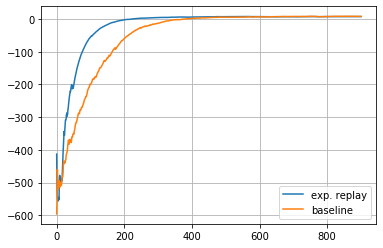

In [7]:
from IPython.display import clear_output
from pandas import DataFrame
moving_average = lambda x, span=100: DataFrame({'x':np.asarray(x)}).x.ewm(span=span).mean().values

rewards_replay, rewards_baseline = [], []

for i in range(1000):
    rewards_replay.append(play_and_train_with_replay(env, agent_replay, replay))
    rewards_baseline.append(play_and_train_with_replay(env, agent_baseline, replay=None))
    
    agent_replay.epsilon *= 0.99
    agent_baseline.epsilon *= 0.99
    
    if i %100 ==0:
        clear_output(True)
        print('Baseline : eps =', agent_replay.epsilon, 'mean reward =', np.mean(rewards_baseline[-10:]))
        print('ExpReplay: eps =', agent_baseline.epsilon, 'mean reward =', np.mean(rewards_replay[-10:]))
        plt.plot(moving_average(rewards_replay), label='exp. replay')
        plt.plot(moving_average(rewards_baseline), label='baseline')
        plt.grid()
        plt.legend()
        plt.show()
        

### Submit to Coursera

In [8]:
from submit import submit_experience_replay
submit_experience_replay(rewards_replay, rewards_baseline, 'rajvirdhakhada7@gmail.com', 'jmOXGlwpm6K6peP4')

Submission to Coursera returned with HTTP status code 401.
You can try generating a new token and make sure you spelled it correctly.
Here is the full response:
{'details': None,
 'errorCode': 'invalidEmailOrToken',
 'message': 'Invalid email or token.'}


#### What to expect:

Experience replay, if implemented correctly, will improve algorithm's initial convergence a lot, but it shouldn't affect the final performance.

### Outro

We will use the code you just wrote extensively in the next week of our course. If you're feeling that you need more examples to understand how experience replay works, try using it for binarized state spaces (CartPole or other __[classic control envs](https://gym.openai.com/envs/#classic_control)__).

__Next week__ we're gonna explore how q-learning and similar algorithms can be applied for large state spaces, with deep learning models to approximate the Q function.

However, __the code you've written__ for this week is already capable of solving many RL problems, and as an added benifit - it is very easy to detach. You can use Q-learning, SARSA and Experience Replay for any RL problems you want to solve - just thow 'em into a file and import the stuff you need.